# Recognition of flower types 

The 102-flowers dataset was <a href=http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html>created by the Visual Geometry Group of Oxford University, and contains at least 40 examples for each of 102 types of flowers</a>. The <a href=http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html>102 categories (and numbers of examples for each) is described HERE</a>.

<b>The goal on this dataset is to use TRANSFER LEARNING from one of standard ConvNets (Inception, ResNet, etc) pre-trained on ImageNet, in order to learn a classifier able to recognize/discriminate the 102 types of flowers.</b>

Note that there is also a smaller dataset, <a href=http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html>17-flowers, with 80 examples for each of 17 categories of flowers</a>, which you could use as an alternative.


### Step 1: Data loading and formatting

First we download our data

In [ ]:
!wget https://cloud.mines-paristech.fr/index.php/s/ekN3uXoJSrbbSD8/download
!unzip download

In [ ]:
# tools in use
import os
from shutil import copyfile
from collections import OrderedDict
import time,json
import copy

import numpy as np
import scipy.io
from sklearn.utils import shuffle

%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

from torchvision import models
from torchsummary import summary


from __future__ import print_function, division

Then we load our labels

In [ ]:
# First, load labels
img_labels_mat = scipy.io.loadmat('102_flower-types_dataset/imagelabels.mat')
print(img_labels_mat)
img_labels = img_labels_mat.get('labels')
print(img_labels[0].shape)
targets = img_labels[0]

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009', '__version__': '1.0', '__globals__': [], 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}
(8189,)


We split our data into **training** , **validation** and **testing** sets.

In [ ]:
# Then load IDs of train/valid/test files
train_test_split = scipy.io.loadmat('102_flower-types_dataset/setid.mat')
print(train_test_split)
print()
trainIDs = train_test_split.get('trnid')[0]
print(str(trainIDs.size)+" examples in original training set")
#print("IDs of the "+str(trainIDs.size)+" training images: "+str(trainIDs))
validIDs = train_test_split.get('valid')[0]
print(str(validIDs.size)+" examples in original validation set")
#print("IDs of the "+str(validIDs.size)+" validation images: "+str(validIDs))
testIDs = train_test_split.get('tstid')[0]
print(str(testIDs.size)+" examples in original test set")
#print("IDs of the "+str(testIDs.size)+" test images: "+str(testIDs))

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009', '__version__': '1.0', '__globals__': [], 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16), 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16), 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

1020 examples in original training set
1020 examples in original validation set
6149 examples in original test set


We load the **training images**.


 Loaded 1020 images from original training set

Sanity check of training set

102_flower-types_dataset/jpg/image_06423.jpg
ClassID=9


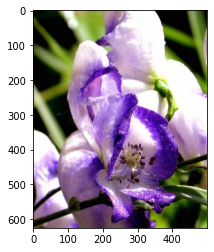


102_flower-types_dataset/jpg/image_08041.jpg
ClassID=102


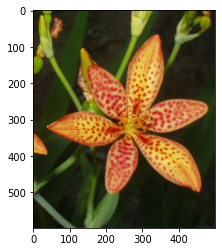


102_flower-types_dataset/jpg/image_06040.jpg
ClassID=93


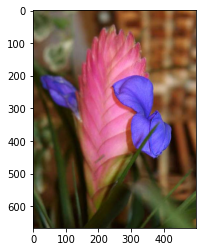

In [ ]:
# LOAD IMAGES 

# Load examples from original training set
imgNames_train = []
images_train = []
labels_train = []
for i in range(0,trainIDs.size):
    id = trainIDs[i]
    filename = "102_flower-types_dataset/jpg/image_"+format(id, '05d')+".jpg"
    imgNames_train.append(filename)
    images_train.append(plt.imread(filename))
    labels_train.append(targets[id-1])
print("\n Loaded "+str(trainIDs.size)+" images from original training set\n")
# Shuffle the training set (originally ordered by class after loading)
X_train_img, y_train, filenames_train = shuffle(images_train, labels_train, imgNames_train)
# Sanity check
print("Sanity check of training set\n")
for i in range(0,3):
    print(filenames_train[i])
    print("ClassID="+str(y_train[i]))
    plt.imshow(X_train_img[i])
    plt.show()
    print()


Then the **validation set images**.


 Loaded 1020 images from original validation set

Sanity check of validation set

102_flower-types_dataset/jpg/image_00741.jpg
ClassID=89


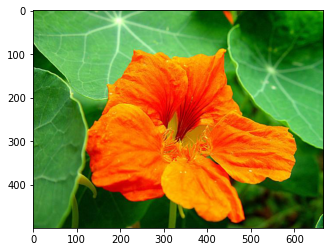


102_flower-types_dataset/jpg/image_01751.jpg
ClassID=83


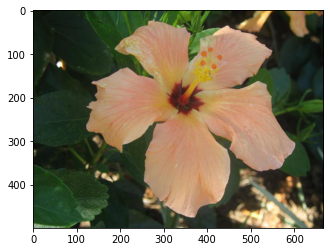


102_flower-types_dataset/jpg/image_06465.jpg
ClassID=33


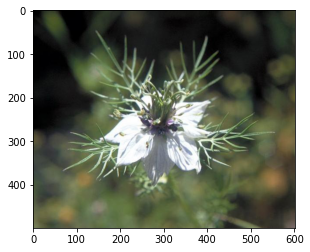

In [ ]:
# LOAD IMAGES 
    
# Load examples from original validation set
imgNames_valid = []
images_valid = []
labels_valid = []
for i in range(0,validIDs.size):
    id = validIDs[i]
    filename = "102_flower-types_dataset/jpg/image_"+format(id, '05d')+".jpg"
    imgNames_valid.append(filename)
    images_valid.append(plt.imread(filename))
    labels_valid.append(targets[id-1])
print("\n Loaded "+str(validIDs.size)+" images from original validation set\n")
# Shuffle the training set (originally ordered by class after loading)
X_valid_img, y_valid, filenames_valid = shuffle(images_valid, labels_valid, imgNames_valid)
# Sanity check
print("Sanity check of validation set\n")
for i in range(0,3):
    print(filenames_valid[i])
    print("ClassID="+str(y_valid[i]))
    plt.imshow(X_valid_img[i])
    plt.show()
    print()

And for the last the **testing set images**.


 Loaded 6149 images from original test set

Sanity check of test set

102_flower-types_dataset/jpg/image_02512.jpg
ClassID=76


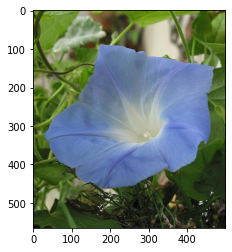


102_flower-types_dataset/jpg/image_00804.jpg
ClassID=81


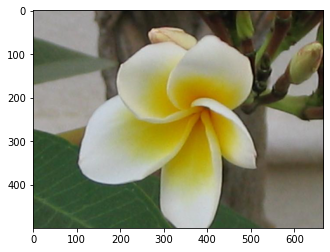


102_flower-types_dataset/jpg/image_04924.jpg
ClassID=20


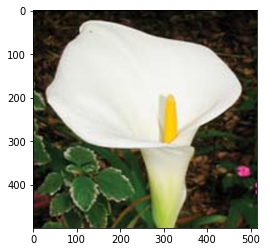

In [ ]:
# LOAD IMAGES 

# Load examples from original test set
imgNames_test = []
images_test = []
labels_test = []
for i in range(0,testIDs.size):
    id = testIDs[i]
    filename = "102_flower-types_dataset/jpg/image_"+format(id, '05d')+".jpg"
    imgNames_test.append(filename)
    images_test.append(plt.imread(filename))
    labels_test.append(targets[id-1])
print("\n Loaded "+str(testIDs.size)+" images from original test set\n")
# Shuffle the training set (originally ordered by class after loading)
X_test_img, y_test, filenames_test = shuffle(images_test, labels_test, imgNames_test)
# Sanity check
print("Sanity check of test set\n")
for i in range(0,3):
    print(filenames_test[i])
    print("ClassID="+str(y_test[i]))
    plt.imshow(X_test_img[i])
    plt.show()
    print()
    

We organize our data into folders. Structured by type and then by class Id. 

In [ ]:
###########################
###### RUN ONLY ONCE!######
###########################

# folders structure
os.mkdir("data")
os.mkdir("data/train")
os.mkdir("data/val")
os.mkdir("data/test")
for cl in set(img_labels[0].tolist()):
    os.mkdir("data/train/" + str(cl))
    os.mkdir("data/val/" + str(cl))
    os.mkdir("data/test/" + str(cl))

# folders seeding - data migration

for i in range(0, trainIDs.size):
    copyfile(
       filenames_train[i],
        "data/train/" + str(y_train[i]) +
            "/" + filenames_train[i].replace('102_flower-types_dataset/jpg/', ''))
for i in range(0, validIDs.size):
    copyfile(
        filenames_valid[i] ,
        "data/val/" + str(y_valid[i]) +
            "/" + filenames_valid[i].replace('102_flower-types_dataset/jpg/', ''))
for i in range(0, testIDs.size):
    copyfile(
        filenames_test[i],
        "data/test/" + str(y_test[i]) +
            "/" + filenames_test[i].replace('102_flower-types_dataset/jpg/', ''))

print("Successfully CREATED and SEEDED the folders tree!\nDO NOT RE-RUN THIS CELL!")

Successfully CREATED and SEEDED the folders tree!
DO NOT RE-RUN THIS CELL!


There are two major transfer learning scenarios:

  * **Finetuning the convnet**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
  * **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


We are going to try this two approaches using the **RestNet** as a pretrained Neural Network. 
We can find an implementation of it in **Pytorch**.

According to the Pytorvh description found in their official website [here](https://pytorch.org/hub/pytorch_vision_resnet/)
there are 5 different versions of pretrained ResNet models, which contains 18, 34, 50, 101, 152 layers respectively.

For the simplicity and computational speed we will use the simplest one: **resnet18**. If the results are not that good we will try the next one. 



> #### *Data normalization + augmentation*



Before uploading our model and train it on our data there are some conditions we should fullfill before according to Pytorch:


1.   Our images should be of shape (3 x H x W), where H and W are expected to be at least **224** and 3 represent a 3-channel RGB images.
2.   The images have to be loaded in to a range of [0, 1]
3.   normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


Also We have a small amount of images in the training set in comparison on the test set (1020 for the training and validation for more than 6000 for the test). 
Hence It's highly recommanded to apply some data augmentation techniques to increase the numbers of inputs for the training. 
For exemple we can use the same images but apply some random rotations to generate new images.   

Now let's apply first these transformations to our data. 

In [ ]:
train_dir = 'data/train'
valid_dir = 'data/val'
test_dir = 'data/test'

# Data augmentation and normalization for training
# Just normalization for validation and test

data_transforms = {
    'train': transforms.Compose([transforms.Resize(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(20),
                                        transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]
    ),
    'val_test': transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    ,
}

image_datasets_train = datasets.ImageFolder(train_dir,data_transforms['train'])
image_datasets_valid = datasets.ImageFolder(valid_dir,data_transforms['val_test'])
image_datasets_test = datasets.ImageFolder(test_dir,data_transforms['val_test'])

train_dataloader = torch.utils.data.DataLoader(image_datasets_train,batch_size=64,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(image_datasets_valid,batch_size=64,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(image_datasets_test,batch_size=64,shuffle=True)

class_to_idx = image_datasets_train.class_to_idx
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Step 2: training the model


Now, let’s write a general function to train a model. Here, we will illustrate:

* Scheduling the learning rate
* Saving the best model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataload = train_dataloader
                datasize = trainIDs.size
            else:
                model.eval()   # Set model to evaluate mode
                dataload = valid_dataloader
                datasize = validIDs.size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataload:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if (type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau):
                  print("iciiii")
                  scheduler.step(loss)
                else:           
                  scheduler.step()

            epoch_loss = running_loss / datasize
            epoch_acc = running_corrects.double() / datasize

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 2.1/Finetuning the convnet

### 2.1.1/ Unfreeze all the model parameters




> #### *Classifier selection*





First approach we will try is where we initialize our model with the pretrained **ResNet18** model and reset the final fully connected layer to match our needs. 
For that we change the last FC layer with a linear one that have 102 outputs. 

Note that for know we use common parameters for the criterion (cross entropy loss), the optimizer (SGD) and it momentum(0.9) and learning rate(0.001)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here we set the size of each output sample is set to len(class_names).
model_ft.fc = nn.Linear(num_ftrs, len(set(img_labels[0].tolist())))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Let's train and evaluate our model


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7695 Acc: 0.0108
val Loss: 4.6679 Acc: 0.0167

Epoch 1/24
----------
train Loss: 4.5628 Acc: 0.0275
val Loss: 4.4568 Acc: 0.0353

Epoch 2/24
----------
train Loss: 4.3376 Acc: 0.0833
val Loss: 4.2524 Acc: 0.0853

Epoch 3/24
----------
train Loss: 4.1342 Acc: 0.1676
val Loss: 4.0366 Acc: 0.1863

Epoch 4/24
----------
train Loss: 3.9192 Acc: 0.2422
val Loss: 3.7838 Acc: 0.2735

Epoch 5/24
----------
train Loss: 3.6923 Acc: 0.3157
val Loss: 3.5382 Acc: 0.3608

Epoch 6/24
----------
train Loss: 3.4196 Acc: 0.4510
val Loss: 3.2926 Acc: 0.4167

Epoch 7/24
----------
train Loss: 3.2922 Acc: 0.4716
val Loss: 3.2864 Acc: 0.4284

Epoch 8/24
----------
train Loss: 3.2801 Acc: 0.4922
val Loss: 3.2597 Acc: 0.4314

Epoch 9/24
----------
train Loss: 3.2479 Acc: 0.4902
val Loss: 3.2373 Acc: 0.4451

Epoch 10/24
----------
train Loss: 3.2425 Acc: 0.4961
val Loss: 3.2107 Acc: 0.4510

Epoch 11/24
----------
train Loss: 3.2011 Acc: 0.4892
val Loss: 3.1861 Acc: 0.4549

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 42.99%


the Accuracy of our model is quite low as seen here lower than 50%. 
This is probably because we are using a simple Linear transformation at the last layer. Since in the neural network the last layers are the ones that detect the more complicated features, (i.e the more valuable informations) we should probably try to use a more complicated layers to replace the final fc layer than a simple linear transformation. 

A common way to do so is to use a **combination of conventional Linear and Dropout layers** in the FC layers. 
Let's try this approach below.


In [ ]:
model_ft2 = models.resnet18(pretrained=True)
num_ftrs = model_ft2.fc.in_features

classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(num_ftrs,num_ftrs*8)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc2', nn.Linear(num_ftrs*8, len(set(img_labels[0].tolist())))),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))
model_ft2.fc = classifier

model_ft2 = model_ft2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Let's train and evaluate our model


In [ ]:
model_ft2 = train_model(model_ft2, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.6761 Acc: 0.0118
val Loss: 4.5763 Acc: 0.0225

Epoch 1/24
----------
train Loss: 4.5796 Acc: 0.0206
val Loss: 4.4637 Acc: 0.0902

Epoch 2/24
----------
train Loss: 4.4639 Acc: 0.0471
val Loss: 4.3450 Acc: 0.2010

Epoch 3/24
----------
train Loss: 4.3373 Acc: 0.0971
val Loss: 4.2101 Acc: 0.2794

Epoch 4/24
----------
train Loss: 4.1994 Acc: 0.1784
val Loss: 4.0655 Acc: 0.3843

Epoch 5/24
----------
train Loss: 4.0388 Acc: 0.2559
val Loss: 3.8927 Acc: 0.4667

Epoch 6/24
----------
train Loss: 3.8737 Acc: 0.3363
val Loss: 3.6975 Acc: 0.5196

Epoch 7/24
----------
train Loss: 3.7377 Acc: 0.4088
val Loss: 3.6812 Acc: 0.5353

Epoch 8/24
----------
train Loss: 3.7459 Acc: 0.3990
val Loss: 3.6608 Acc: 0.5392

Epoch 9/24
----------
train Loss: 3.7019 Acc: 0.4206
val Loss: 3.6407 Acc: 0.5412

Epoch 10/24
----------
train Loss: 3.6935 Acc: 0.4069
val Loss: 3.6186 Acc: 0.5451

Epoch 11/24
----------
train Loss: 3.6565 Acc: 0.4392
val Loss: 3.5987 Acc: 0.5451

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft2.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft2.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 54.90%


Let's consider another classifier where we add **AdaptivePooling Layers**.
The pooling layers capture richer features from the convolutional layers and we need to provide them as best as possible to the Classifier so they could classify easily and this would also effectively reduce the number of linear layers we need. This implementation is outlined is fast.ai library and re implementation of it can be found below:


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        #print('tontont',input.size(0))
        return input.view(input.size(0), -1)
     
class ClassifierNew(nn.Module):
    def __init__(self, inp = 512, h1=1024, out = 102, d=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(d)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(d)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        #print('x',x)
        #print('x.shape', x.shape)
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        
        return x

Let's use it to replace our last fc layer of our resnet18:

---



In [ ]:
model_ft3 = models.resnet18(pretrained=True)
model_ft3 = torch.nn.Sequential(*(list(model_ft3.children())[:-1]))
classifier = ClassifierNew()


#print(model_ft3)

#model_ft3 = model_ft3.to(device)
#summary(model_ft3, (3, 224, 224))

model_ft3.avgpool=classifier

#print(model_ft3)


model_ft3 = model_ft3.to(device)
summary(model_ft3, (3, 224, 224))

#classifier = classifier.to(device)
#print(classifier)
#summary(classifier, (512,7,7))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model_ft3 = train_model(model_ft3, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7930 Acc: 0.0186
val Loss: 4.5210 Acc: 0.0235

Epoch 1/24
----------
train Loss: 4.5002 Acc: 0.0314
val Loss: 4.1453 Acc: 0.1382

Epoch 2/24
----------
train Loss: 4.1377 Acc: 0.1059
val Loss: 3.7142 Acc: 0.2941

Epoch 3/24
----------
train Loss: 3.7151 Acc: 0.2196
val Loss: 3.2626 Acc: 0.4235

Epoch 4/24
----------
train Loss: 3.2824 Acc: 0.3598
val Loss: 2.8481 Acc: 0.5324

Epoch 5/24
----------
train Loss: 2.9133 Acc: 0.4412
val Loss: 2.4936 Acc: 0.5863

Epoch 6/24
----------
train Loss: 2.5635 Acc: 0.5304
val Loss: 2.2090 Acc: 0.6412

Epoch 7/24
----------
train Loss: 2.4160 Acc: 0.5667
val Loss: 2.1942 Acc: 0.6510

Epoch 8/24
----------
train Loss: 2.3781 Acc: 0.5725
val Loss: 2.1834 Acc: 0.6510

Epoch 9/24
----------
train Loss: 2.3308 Acc: 0.5990
val Loss: 2.1600 Acc: 0.6539

Epoch 10/24
----------
train Loss: 2.3181 Acc: 0.5902
val Loss: 2.1329 Acc: 0.6569

Epoch 11/24
----------
train Loss: 2.2840 Acc: 0.5922
val Loss: 2.1049 Acc: 0.6725

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft3.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft3.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 63.52%


The results **increase almost by 20%** since the simple linear layer. let's see if we can do more by changing other hyperparameters.



> #### *Optimizer*



let's try know to improve our result by changing our optimizer. 
According to the literature **ADAM** optimizer it the most recomendend one for non sparse data. The intuition behind it is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search. 

let's try it first.

In [ ]:
model_ft4 = models.resnet18(pretrained=True)
model_ft4 = torch.nn.Sequential(*(list(model_ft3.children())[:-1]))
classifier = ClassifierNew()

model_ft4.avgpool=classifier


model_ft4 = model_ft4.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft4.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft4 = train_model(model_ft4, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.8747 Acc: 0.1500
val Loss: 5.3453 Acc: 0.1098

Epoch 1/24
----------
train Loss: 2.5584 Acc: 0.3804
val Loss: 2.2673 Acc: 0.4304

Epoch 2/24
----------
train Loss: 1.9373 Acc: 0.5118
val Loss: 2.3527 Acc: 0.4225

Epoch 3/24
----------
train Loss: 1.5017 Acc: 0.6069
val Loss: 2.1025 Acc: 0.4735

Epoch 4/24
----------
train Loss: 1.2706 Acc: 0.6490
val Loss: 1.8788 Acc: 0.5108

Epoch 5/24
----------
train Loss: 1.0327 Acc: 0.7225
val Loss: 1.8165 Acc: 0.5569

Epoch 6/24
----------
train Loss: 0.9246 Acc: 0.7520
val Loss: 1.3638 Acc: 0.6451

Epoch 7/24
----------
train Loss: 0.7066 Acc: 0.8275
val Loss: 0.8590 Acc: 0.7618

Epoch 8/24
----------
train Loss: 0.5593 Acc: 0.8657
val Loss: 0.7393 Acc: 0.8039

Epoch 9/24
----------
train Loss: 0.4952 Acc: 0.8755
val Loss: 0.6996 Acc: 0.8069

Epoch 10/24
----------
train Loss: 0.4552 Acc: 0.8971
val Loss: 0.6800 Acc: 0.8304

Epoch 11/24
----------
train Loss: 0.4033 Acc: 0.9059
val Loss: 0.6872 Acc: 0.8196

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft4.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft4.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 81.81%


We jumped to over 81% just by choosing a right optimzer. That's show the importent of the optimizer for the model.
According to some paper, it's seems that all the popular Deep Learning frameworks (Tensorflow, Pytorch) have implemented Adam with weight decay wrong. They used L2 regularization as a weight decay which are not totataly the same thing. A new implementation of ADAM called **ADAMW** seems to correct that issue and bring better convergence. 

Let's try it bellow:

**ADAMW**

In [ ]:
model_ft5 = models.resnet18(pretrained=True)
model_ft5 = torch.nn.Sequential(*(list(model_ft5.children())[:-1]))
classifier = ClassifierNew()

model_ft5.avgpool=classifier


model_ft5 = model_ft5.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft5.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft5 = train_model(model_ft5, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.0087 Acc: 0.1353
val Loss: 4.7304 Acc: 0.0882

Epoch 1/24
----------
train Loss: 2.6132 Acc: 0.3588
val Loss: 2.6950 Acc: 0.3922

Epoch 2/24
----------
train Loss: 1.9436 Acc: 0.4961
val Loss: 2.2661 Acc: 0.4441

Epoch 3/24
----------
train Loss: 1.4778 Acc: 0.6373
val Loss: 1.7963 Acc: 0.5510

Epoch 4/24
----------
train Loss: 1.1783 Acc: 0.6843
val Loss: 1.8920 Acc: 0.5206

Epoch 5/24
----------
train Loss: 0.9505 Acc: 0.7461
val Loss: 1.5061 Acc: 0.6176

Epoch 6/24
----------
train Loss: 0.9025 Acc: 0.7608
val Loss: 1.3947 Acc: 0.6461

Epoch 7/24
----------
train Loss: 0.7238 Acc: 0.8176
val Loss: 0.8114 Acc: 0.7706

Epoch 8/24
----------
train Loss: 0.5412 Acc: 0.8824
val Loss: 0.7207 Acc: 0.8059

Epoch 9/24
----------
train Loss: 0.4565 Acc: 0.8951
val Loss: 0.6828 Acc: 0.8157

Epoch 10/24
----------
train Loss: 0.4579 Acc: 0.8961
val Loss: 0.6621 Acc: 0.8324

Epoch 11/24
----------
train Loss: 0.4181 Acc: 0.9059
val Loss: 0.6493 Acc: 0.8333

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft5.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft5.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 82.27%


As expected we got a slightly better result that before over 82%.



> #### *Learning rate scheduling*



let's try to improve the learning rate scheduler. 

The key idea here is to iteratively reduce the learning rate after every few epochs so that the optimizer would reach global/best local optima without any huge oscillations.


The most popular form of learning rate annealing is a step decay where the learning rate is reduced by some percentage after a set number of training epochs. It's the one we used until now.
Another commmon one is ReduceLRonPlateau. 
Let's try it first.


In [ ]:
model_ft6 = models.resnet18(pretrained=True)
model_ft6 = torch.nn.Sequential(*(list(model_ft6.children())[:-1]))
classifier = ClassifierNew()

model_ft6.avgpool=classifier


model_ft6 = model_ft6.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft6.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft)

In [ ]:
model_ft6 = train_model(model_ft6, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
iciiii
train Loss: 1.1101 Acc: 0.6971
val Loss: 1.6397 Acc: 0.5853

Epoch 1/24
----------
iciiii
train Loss: 1.0381 Acc: 0.7255
val Loss: 1.4570 Acc: 0.6294

Epoch 2/24
----------
iciiii
train Loss: 0.9100 Acc: 0.7559
val Loss: 1.8232 Acc: 0.5431

Epoch 3/24
----------
iciiii
train Loss: 0.7873 Acc: 0.7902
val Loss: 1.3182 Acc: 0.6735

Epoch 4/24
----------
iciiii
train Loss: 0.6907 Acc: 0.8186
val Loss: 1.4688 Acc: 0.6284

Epoch 5/24
----------
iciiii
train Loss: 0.6214 Acc: 0.8402
val Loss: 1.2652 Acc: 0.6784

Epoch 6/24
----------
iciiii
train Loss: 0.6546 Acc: 0.8275
val Loss: 1.6100 Acc: 0.6245

Epoch 7/24
----------
iciiii
train Loss: 0.6235 Acc: 0.8324
val Loss: 1.5415 Acc: 0.6167

Epoch 8/24
----------
iciiii
train Loss: 0.6105 Acc: 0.8275
val Loss: 1.3738 Acc: 0.6637

Epoch 9/24
----------
iciiii
train Loss: 0.5816 Acc: 0.8431
val Loss: 1.2102 Acc: 0.7029

Epoch 10/24
----------
iciiii
train Loss: 0.5889 Acc: 0.8451
val Loss: 1.2594 Acc: 0.7010

Epoch 11/

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft6.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft6.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 70.78%


This one reduce our testing accuracy, hence we will not use it. 

Another new technique I found in the literature is called **cyclic learning rates**. The intuition behind this technique is that it adapt the learning rate in an exponential decay which seems more efficient than a fixed decay. This is achieved by reducing the size of the "triangle" where the top represent the maximum learning rate and the base the minimum. At each cycle the max learning rate is reduced, hence the learning rate decay is exponentially adapted. 

Let's implement it below and use it. 

In [ ]:
import math
def cyclical_lr(step_sz, min_lr=0.001, max_lr=1, mode='triangular', scale_func=None, scale_md='cycles', gamma=1.):
    if scale_func == None:
        if mode == 'triangular':
            scale_fn = lambda x: 1.
            scale_mode = 'cycles'
        elif mode == 'triangular2':
            scale_fn = lambda x: 1 / (2.**(x - 1))
            scale_mode = 'cycles'
        elif mode == 'exp_range':
            scale_fn = lambda x: gamma**(x)
            scale_mode = 'iterations'
        else:
            raise ValueError(f'The {mode} is not valid value!')
    else:
        scale_fn = scale_func
        scale_mode = scale_md    
        
    lr_lambda = lambda iters: min_lr + (max_lr - min_lr) * rel_val(iters, step_sz, scale_mode)    
    
    def rel_val(iteration, stepsize, mode):
        cycle = math.floor(1 + iteration / (2 * stepsize))
        x = abs(iteration / stepsize - 2 * cycle + 1)
        if mode == 'cycles':
            return max(0, (1 - x)) * scale_fn(cycle)
        elif mode == 'iterations':
            return max(0, (1 - x)) * scale_fn(iteration)
        else:
            raise ValueError(f'The {scale_mode} is not valid value!')    
    return lr_lambda



In [ ]:
model_ft7 = models.resnet18(pretrained=True)
model_ft7 = torch.nn.Sequential(*(list(model_ft7.children())[:-1]))
classifier = ClassifierNew()

model_ft7.avgpool=classifier


model_ft7 = model_ft7.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft7.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

clr = cyclical_lr(step_sz=7, min_lr=0.001, max_lr=1, mode='triangular2')
scheduler = optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
scheduler.step()
optimizer_ft.step()
#scheduler.step()


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
model_ft7 = train_model(model_ft7, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.5497 Acc: 0.0422
val Loss: 4.0023 Acc: 0.2588

Epoch 1/24
----------
train Loss: 3.3143 Acc: 0.3098
val Loss: 2.3796 Acc: 0.5725

Epoch 2/24
----------
train Loss: 2.1401 Acc: 0.6020
val Loss: 1.4528 Acc: 0.6833

Epoch 3/24
----------
train Loss: 1.3296 Acc: 0.7520
val Loss: 1.2291 Acc: 0.7314

Epoch 4/24
----------
train Loss: 0.9664 Acc: 0.8088
val Loss: 1.0981 Acc: 0.7392

Epoch 5/24
----------
train Loss: 0.7548 Acc: 0.8490
val Loss: 0.8504 Acc: 0.7765

Epoch 6/24
----------
train Loss: 0.7769 Acc: 0.8157
val Loss: 1.1535 Acc: 0.7167

Epoch 7/24
----------
train Loss: 0.7682 Acc: 0.8216
val Loss: 1.1660 Acc: 0.6833

Epoch 8/24
----------
train Loss: 0.5777 Acc: 0.8667
val Loss: 0.9650 Acc: 0.7657

Epoch 9/24
----------
train Loss: 0.4406 Acc: 0.9020
val Loss: 0.6680 Acc: 0.8265

Epoch 10/24
----------
train Loss: 0.3275 Acc: 0.9186
val Loss: 0.5481 Acc: 0.8569

Epoch 11/24
----------
train Loss: 0.2852 Acc: 0.9422
val Loss: 0.4933 Acc: 0.8775

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_ft7.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_ft7.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 87.53%


We raised our performence by more than 5% since our last best score of 82% to reach **87.53%**.



> #### *Freeze all the model parameters and update only the last layer.*





As discussed at the beginning there are two ways to apply the transfer learning. Use the pretrained model as in initialization for our new model (this is what we did until now). Update only the last layer (i.e classifier part). 
We are going to try this second method below and see how it behave. 

In [ ]:
model_fz = models.resnet18(pretrained=True)
for param in model_fz.parameters():
    param.requires_grad = False
model_fz = torch.nn.Sequential(*(list(model_fz.children())[:-1]))
classifier = ClassifierNew()

model_fz.avgpool=classifier


model_fz = model_fz.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_fz.parameters(), lr=0.001)

clr = cyclical_lr(step_sz=7, min_lr=0.001, max_lr=1, mode='triangular2')
scheduler = optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
scheduler.step()
optimizer_ft.step()


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
model_fz = train_model(model_fz, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.6983 Acc: 0.0314
val Loss: 4.3440 Acc: 0.0951

Epoch 1/24
----------
train Loss: 3.9736 Acc: 0.1598
val Loss: 3.3953 Acc: 0.4157

Epoch 2/24
----------
train Loss: 3.0370 Acc: 0.4078
val Loss: 2.3816 Acc: 0.5843

Epoch 3/24
----------
train Loss: 2.1869 Acc: 0.5912
val Loss: 1.7122 Acc: 0.6824

Epoch 4/24
----------
train Loss: 1.5617 Acc: 0.7098
val Loss: 1.3209 Acc: 0.7137

Epoch 5/24
----------
train Loss: 1.2295 Acc: 0.7657
val Loss: 1.1053 Acc: 0.7588

Epoch 6/24
----------
train Loss: 0.9674 Acc: 0.8088
val Loss: 0.9758 Acc: 0.7755

Epoch 7/24
----------
train Loss: 0.8418 Acc: 0.8314
val Loss: 0.8758 Acc: 0.8039

Epoch 8/24
----------
train Loss: 0.7496 Acc: 0.8480
val Loss: 0.8389 Acc: 0.8039

Epoch 9/24
----------
train Loss: 0.6517 Acc: 0.8657
val Loss: 0.8155 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.6902 Acc: 0.8412
val Loss: 0.8120 Acc: 0.8108

Epoch 11/24
----------
train Loss: 0.6423 Acc: 0.8725
val Loss: 0.7947 Acc: 0.8147

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_fz.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_fz.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 81.00%


As we can expect when we train only the last part even it's faster, the result il much lower than if we trained all the model. This is because our fully retrained model is more adapted for our image dataset. But we lost the generalization of the pretrained model. 

So what if we retrain only the last layers (not only the last one i.e the classifier) since the last layers are the one that handle more complicated features and we keep the real fine tuning of the first ones that provides us the pretrained model, since it has been trained one much furnished dataset and it's probably really good to capture the simpliest features. 

### 2.1.2/ unfreezing layers selectivly


let's check first the name of our model layers:

In [ ]:
model_tuned = models.resnet18(pretrained=True)

for name, child in model.named_children():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


let's select only the two last layerq (**layer 3 and layer 4**) for the update.

In [ ]:
for name, child in model_tuned.named_children():
   if name in ['layer3', 'layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


In the optimizer we will specify only the layers that should be optimized. The rest is as before.

In [ ]:
model_tuned = torch.nn.Sequential(*(list(model_tuned.children())[:-1]))
classifier = ClassifierNew()

model_tuned.avgpool=classifier


model_tuned = model_tuned.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#N.B: we shoud optimize only the right parameters
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model_tuned.parameters()), lr=0.001)

clr = cyclical_lr(step_sz=7, min_lr=0.001, max_lr=1, mode='triangular2')
scheduler = optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
scheduler.step()
optimizer_ft.step()


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
model_tuned = train_model(model_tuned, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.5488 Acc: 0.0461
val Loss: 4.0461 Acc: 0.2490

Epoch 1/24
----------
train Loss: 3.2689 Acc: 0.3422
val Loss: 2.2850 Acc: 0.5804

Epoch 2/24
----------
train Loss: 2.0239 Acc: 0.6373
val Loss: 1.3456 Acc: 0.7451

Epoch 3/24
----------
train Loss: 1.2719 Acc: 0.7745
val Loss: 1.0453 Acc: 0.7696

Epoch 4/24
----------
train Loss: 0.8181 Acc: 0.8500
val Loss: 0.7969 Acc: 0.8245

Epoch 5/24
----------
train Loss: 0.5989 Acc: 0.8863
val Loss: 0.7455 Acc: 0.8373

Epoch 6/24
----------
train Loss: 0.6243 Acc: 0.8637
val Loss: 0.8228 Acc: 0.7951

Epoch 7/24
----------
train Loss: 0.5929 Acc: 0.8706
val Loss: 0.8440 Acc: 0.7804

Epoch 8/24
----------
train Loss: 0.4907 Acc: 0.8853
val Loss: 0.7169 Acc: 0.7971

Epoch 9/24
----------
train Loss: 0.3654 Acc: 0.9098
val Loss: 0.6481 Acc: 0.8363

Epoch 10/24
----------
train Loss: 0.3107 Acc: 0.9324
val Loss: 0.5278 Acc: 0.8755

Epoch 11/24
----------
train Loss: 0.2709 Acc: 0.9343
val Loss: 0.4675 Acc: 0.8843

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_tuned.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_tuned.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 87.94%


Well we managed to increase further more our performence and almost reach **88%**



> #### *Increasing size of the ResNet*



According to the literature **ResNet50** gives a good balance between model size, computation time and error rate. We will use it instead of **ResNet18** and see how it behave. 

In [ ]:
model_tuned2 = models.resnet50(pretrained=True)
for name, child in model_tuned2.named_children():
   if name in ['layer3', 'layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_tuned2 = torch.nn.Sequential(*(list(model_tuned2.children())[:-1]))
classifier = ClassifierNew(inp=2048)

model_tuned2.avgpool=classifier


model_tuned2 = model_tuned2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#N.B: we shoud optimize only the right parameters
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model_tuned2.parameters()), lr=0.001)

clr = cyclical_lr(step_sz=7, min_lr=0.001, max_lr=1, mode='triangular2')
scheduler = optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
scheduler.step()
optimizer_ft.step()


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
model_tuned2 = train_model(model_tuned2, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.0553 Acc: 0.1500
val Loss: 3.4986 Acc: 0.4931

Epoch 1/24
----------
train Loss: 2.0542 Acc: 0.6029
val Loss: 1.2652 Acc: 0.7520

Epoch 2/24
----------
train Loss: 1.0677 Acc: 0.7961
val Loss: 0.9422 Acc: 0.7824

Epoch 3/24
----------
train Loss: 0.6888 Acc: 0.8696
val Loss: 0.8082 Acc: 0.8216

Epoch 4/24
----------
train Loss: 0.6423 Acc: 0.8451
val Loss: 1.0274 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.6826 Acc: 0.8284
val Loss: 1.3700 Acc: 0.6814

Epoch 6/24
----------
train Loss: 0.7372 Acc: 0.8275
val Loss: 1.2389 Acc: 0.6833

Epoch 7/24
----------
train Loss: 0.6628 Acc: 0.8324
val Loss: 1.0680 Acc: 0.7471

Epoch 8/24
----------
train Loss: 0.5996 Acc: 0.8422
val Loss: 0.8360 Acc: 0.7725

Epoch 9/24
----------
train Loss: 0.3802 Acc: 0.9137
val Loss: 0.5890 Acc: 0.8431

Epoch 10/24
----------
train Loss: 0.2759 Acc: 0.9382
val Loss: 0.4620 Acc: 0.8696

Epoch 11/24
----------
train Loss: 0.2032 Acc: 0.9480
val Loss: 0.4377 Acc: 0.8814

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_tuned2.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_tuned2.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 89.58%


Well the resultis good, almost 90%.
We could probably reach higher scores using more complex model, such as densenet or inceptionV3, but we will stop here. 



> #### *Weight decay*



Last thing I want to try on my model is to adapt the weight decay  by adding a L2 regularization.
We do this in the Optimizer by seting up the weight_decay parameter

In [ ]:
model_tuned3 = models.resnet50(pretrained=True)
for name, child in model_tuned3.named_children():
   if name in ['layer3', 'layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_tuned3 = torch.nn.Sequential(*(list(model_tuned3.children())[:-1]))
classifier = ClassifierNew(inp=2048)

model_tuned3.avgpool=classifier


model_tuned3 = model_tuned3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#N.B: we shoud optimize only the right parameters
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model_tuned3.parameters()), lr=0.001, weight_decay=1e-5)

clr = cyclical_lr(step_sz=7, min_lr=0.001, max_lr=1, mode='triangular2')
scheduler = optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
scheduler.step()
optimizer_ft.step()


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
model_tuned3 = train_model(model_tuned3, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.0676 Acc: 0.1392
val Loss: 3.3852 Acc: 0.3716

Epoch 1/24
----------
train Loss: 2.0059 Acc: 0.6225
val Loss: 1.3103 Acc: 0.7333

Epoch 2/24
----------
train Loss: 1.0392 Acc: 0.8157
val Loss: 0.9870 Acc: 0.7902

Epoch 3/24
----------
train Loss: 0.6864 Acc: 0.8657
val Loss: 0.7892 Acc: 0.7971

Epoch 4/24
----------
train Loss: 0.6348 Acc: 0.8549
val Loss: 1.0260 Acc: 0.7647

Epoch 5/24
----------
train Loss: 0.6915 Acc: 0.8314
val Loss: 1.2915 Acc: 0.6647

Epoch 6/24
----------
train Loss: 0.7816 Acc: 0.8088
val Loss: 1.2502 Acc: 0.6882

Epoch 7/24
----------
train Loss: 0.7212 Acc: 0.8206
val Loss: 0.8601 Acc: 0.7696

Epoch 8/24
----------
train Loss: 0.5157 Acc: 0.8745
val Loss: 0.7301 Acc: 0.8020

Epoch 9/24
----------
train Loss: 0.4085 Acc: 0.8961
val Loss: 0.5930 Acc: 0.8471

Epoch 10/24
----------
train Loss: 0.3031 Acc: 0.9294
val Loss: 0.4790 Acc: 0.8755

Epoch 11/24
----------
train Loss: 0.2686 Acc: 0.9343
val Loss: 0.3928 Acc: 0.9039

Ep

In [ ]:
test_accuracy = 0
for images,labels in test_dataloader:
    model_tuned3.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model_tuned3.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 89.63%


Our final score is **89.63%** almost hitting the bar of the 90% which is a nice score.
As said before we can still improve our model by selecting a more complex pretrained model such as the densenet or the inception. We can also try new optimizer such as the SGDR which combine Cosine Cyclic Learning Rate and SGD methods and seems to give better results.  